# Homework 2: SVD and PCA for Machine Learning (Part 3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('./data/train.csv')
print(data.shape)
data = np.array(data)
X = data[:, 1:]
X = X.T

Y = data[:, 0]

print(X.shape, Y.shape)

X_cols, X_rows = X.shape

(42000, 785)
(784, 42000) (42000,)


In [2]:
C1 = 0
C2 = 6
C3 = 9
matrix_filter = (Y==C1) | (Y==C2) | (Y==C3)
filtered_X = X[:, matrix_filter]
filtered_Y = Y[matrix_filter]

In [3]:
num_samples = filtered_X.shape[1]
train_end = int(num_samples * 0.75)
X_train = filtered_X[:, :train_end]
X_test = filtered_X[:, train_end:]

y_train = filtered_Y[:train_end]
y_test = filtered_Y[train_end:]

In [4]:
def compute_projected_matrix(X, k=2):
    centroid_X = np.mean(X, axis=1)
    centroid_X_column = np.reshape(centroid_X, (X_cols, 1))
    X_centered = X - centroid_X_column

    U, _, _ = np.linalg.svd(X_centered, full_matrices=False)
    Uk = U[:, :k]
    P = Uk.T

    Z = P @ X
    return Z, P

In [5]:
Z_train, P = compute_projected_matrix(X_train)

print(Z_train.shape, X_train.shape)

Z1 = Z_train[:, y_train == C1]
Z2 = Z_train[:, y_train == C2]
Z3 = Z_train[:, y_train == C3]

cZ1 = np.mean(Z1, axis = 1)
cZ2 = np.mean(Z2, axis = 1)
cZ3 = np.mean(Z3, axis = 1)

pairs = [(cZ1, Z1), (cZ2, Z2), (cZ3, Z3)]


(2, 9342) (784, 9342)


### Compute distances column by column

In [6]:
avg_distances = []
for c, Z in pairs :
    dist = []
    for i in range(Z.shape[1]):
        dist.append(np.linalg.norm(Z[:, i] - c, ord=2))
    avg_distances.append(np.mean(np.array(dist)))

print(avg_distances)

[727.7249052041926, 538.5406033309062, 362.82208265596626]


The average distance from the centroid in a PCA-projected space essentially measures the spread or dispersion of the data around the centroid along the principal components. It essentially shows how the projection data contains the same variability of the original, uncompressed data. In addition, it shows if the clusters are well separated.

It's similar in its significance to the __standard deviation__ in this sense.

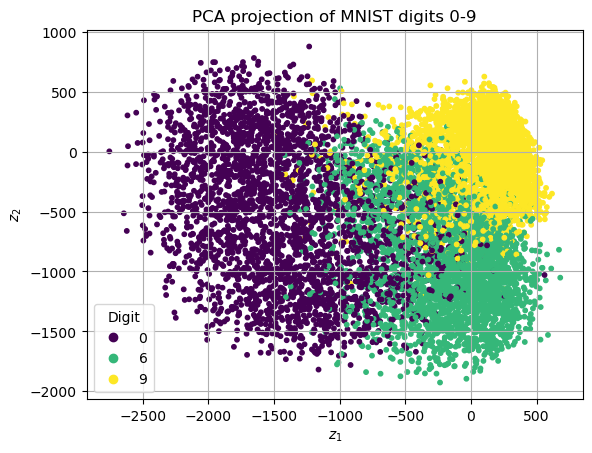

In [7]:
def visualize_clusters(Z_train, Y_train):
    ax = plt.scatter(Z_train[0, :], Z_train[1, :], c=Y_train, s=10)
    plt.legend(*ax.legend_elements(), title="Digit")
    plt.xlabel(r"$z_1$")
    plt.ylabel(r"$z_2$")
    plt.title("PCA projection of MNIST digits 0-9")
    plt.grid()
    plt.show()

visualize_clusters(Z_train, y_train)

### Using $P$ (i.e. $U_k$) on $X_{test}$

In [8]:
Z_test = P @ X_test

In [9]:
Z1_test = Z_test[:, y_test == C1]
Z2_test = Z_test[:, y_test == C2]
Z3_test = Z_test[:, y_test == C3]

pairs_test = [(cZ1, Z1_test), (cZ2, Z2_test), (cZ3, Z3_test)]

avg_distances_test = []
for c, Z in pairs_test :
    dist = []
    for i in range(Z.shape[1]):
        dist.append(np.linalg.norm(Z[:, i] - c, ord=2))
    avg_distances_test.append(np.mean(np.array(dist)))

print(avg_distances_test)

[735.3144435828782, 533.9400884316509, 364.8136333660534]


The average distances are very close to the same found when using the centroid of $X_{test}$, meaning that the distribution of our data in the test set is very similar to the one found in the training set.

## PCA-based classifier

In [10]:
train_centroid = [cZ1, cZ2, cZ3]

def classify(x):
    dist = [np.linalg.norm(x - c) for c in train_centroid]
    labels = [C1, C2, C3]
    y_pred = labels[np.argmin(np.array(dist))]
    return y_pred

count = 0
for i in range(Z_test.shape[1]) :
    x = Z_test[:, i]
    y_pred = classify(x)
    count += (y_pred != y_test[i])

mr = (1/Z_test.shape[1])*count

print(f"Misclassification rate for the PCA-based classifier is {mr}")

Misclassification rate for the PCA-based classifier is 0.14895666131621188


In [11]:
def PCA_classifier(X, Y, labels, k=2):
    C1, C2, C3 = labels
    matrix_filter = (Y==C1) | (Y==C2) | (Y==C3)
    filtered_X = X[:, matrix_filter]
    filtered_Y = Y[matrix_filter]
    num_samples = filtered_X.shape[1]

    train_end = int(num_samples * 0.75)
    X_train = filtered_X[:, :train_end]
    X_test = filtered_X[:, train_end:]

    y_train = filtered_Y[:train_end]
    y_test = filtered_Y[train_end:]

    Z_train, P = compute_projected_matrix(X_train, k)

    Z1 = Z_train[:, y_train == C1]
    Z2 = Z_train[:, y_train == C2]
    Z3 = Z_train[:, y_train == C3]

    cZ1 = np.mean(Z1, axis = 1)
    cZ2 = np.mean(Z2, axis = 1)
    cZ3 = np.mean(Z3, axis = 1)

    pairs = [(cZ1, Z1), (cZ2, Z2), (cZ3, Z3)]

    avg_distances = []
    for c, Z in pairs :
        dist = []
        for i in range(Z.shape[1]):
            dist.append(np.linalg.norm(Z[:, i] - c, ord=2))
        avg_distances.append(np.mean(np.array(dist)))

    print(f"Average distances from c_train on the training set: {avg_distances}")

    Z_test = P @ X_test

    Z1_test = Z_test[:, y_test == C1]
    Z2_test = Z_test[:, y_test == C2]
    Z3_test = Z_test[:, y_test == C3]

    pairs_test = [(cZ1, Z1_test), (cZ2, Z2_test), (cZ3, Z3_test)]

    avg_distances_test = []
    for c, Z in pairs_test :
        dist = []
        for i in range(Z.shape[1]):
            dist.append(np.linalg.norm(Z[:, i] - c, ord=2))
        avg_distances_test.append(np.mean(np.array(dist)))

    print(f"Average distances from c_train on the testing set: {avg_distances_test}")

    train_centroid = [cZ1, cZ2, cZ3]

    def classify(x):
        dist = [np.linalg.norm(x - c) for c in train_centroid]
        labels = [C1, C2, C3]
        y_pred = labels[np.argmin(np.array(dist))]
        return y_pred

    count = 0
    for i in range(Z_test.shape[1]) :
        x = Z_test[:, i]
        y_pred = classify(x)
        count += (y_pred != y_test[i])

    mr = (1/Z_test.shape[1])*count

    print(f"Misclassification rate for the PCA-based classifier is {mr}")
    
    return avg_distances, avg_distances_test, mr


In [12]:
PCA_classifier(X, Y, (0,6,9))

Average distances from c_train on the training set: [727.7249052041926, 538.5406033309062, 362.82208265596626]
Average distances from c_train on the testing set: [735.3144435828782, 533.9400884316509, 364.8136333660534]
Misclassification rate for the PCA-based classifier is 0.14895666131621188


([727.7249052041926, 538.5406033309062, 362.82208265596626],
 [735.3144435828782, 533.9400884316509, 364.8136333660534],
 0.14895666131621188)

In [13]:
pairs = [(1,7,2), (2,5,9), (1,3,8), (3,6,9), (0,6,9)]
ks = [i for i in range(2,10)]

results = {pair: {'MR': [], 'avg_dist': [], 'avg_dist_test': []} for pair in pairs}

for k in ks :
    for labels in pairs:
        print(f'Using k={k} and labels {labels}')
        avg_distances, avg_distances_test, mr = PCA_classifier(X, Y, labels, k)
        print('\n')
        results[labels]['MR'].append(mr)
        results[labels]['avg_dist'].append(np.linalg.norm(avg_distances))
        results[labels]['avg_dist_test'].append(np.linalg.norm(avg_distances_test))

Using k=2 and labels (1, 7, 2)
Average distances from c_train on the training set: [397.8879934643578, 440.00515035531174, 546.7505541897893]
Average distances from c_train on the testing set: [396.0453489697551, 432.84388717968983, 514.7287091698181]
Misclassification rate for the PCA-based classifier is 0.08504221954161639


Using k=2 and labels (2, 5, 9)
Average distances from c_train on the training set: [497.8789169072332, 582.1209281487997, 361.40722031331103]
Average distances from c_train on the testing set: [497.5862674219577, 583.3029941436959, 364.29869202078225]
Misclassification rate for the PCA-based classifier is 0.18355263157894736


Using k=2 and labels (1, 3, 8)
Average distances from c_train on the training set: [455.4716441069129, 559.7258384209626, 573.9718117035038]
Average distances from c_train on the testing set: [452.3785930241147, 567.5693116252457, 574.5039476964977]
Misclassification rate for the PCA-based classifier is 0.20458015267175572


Using k=2 and l

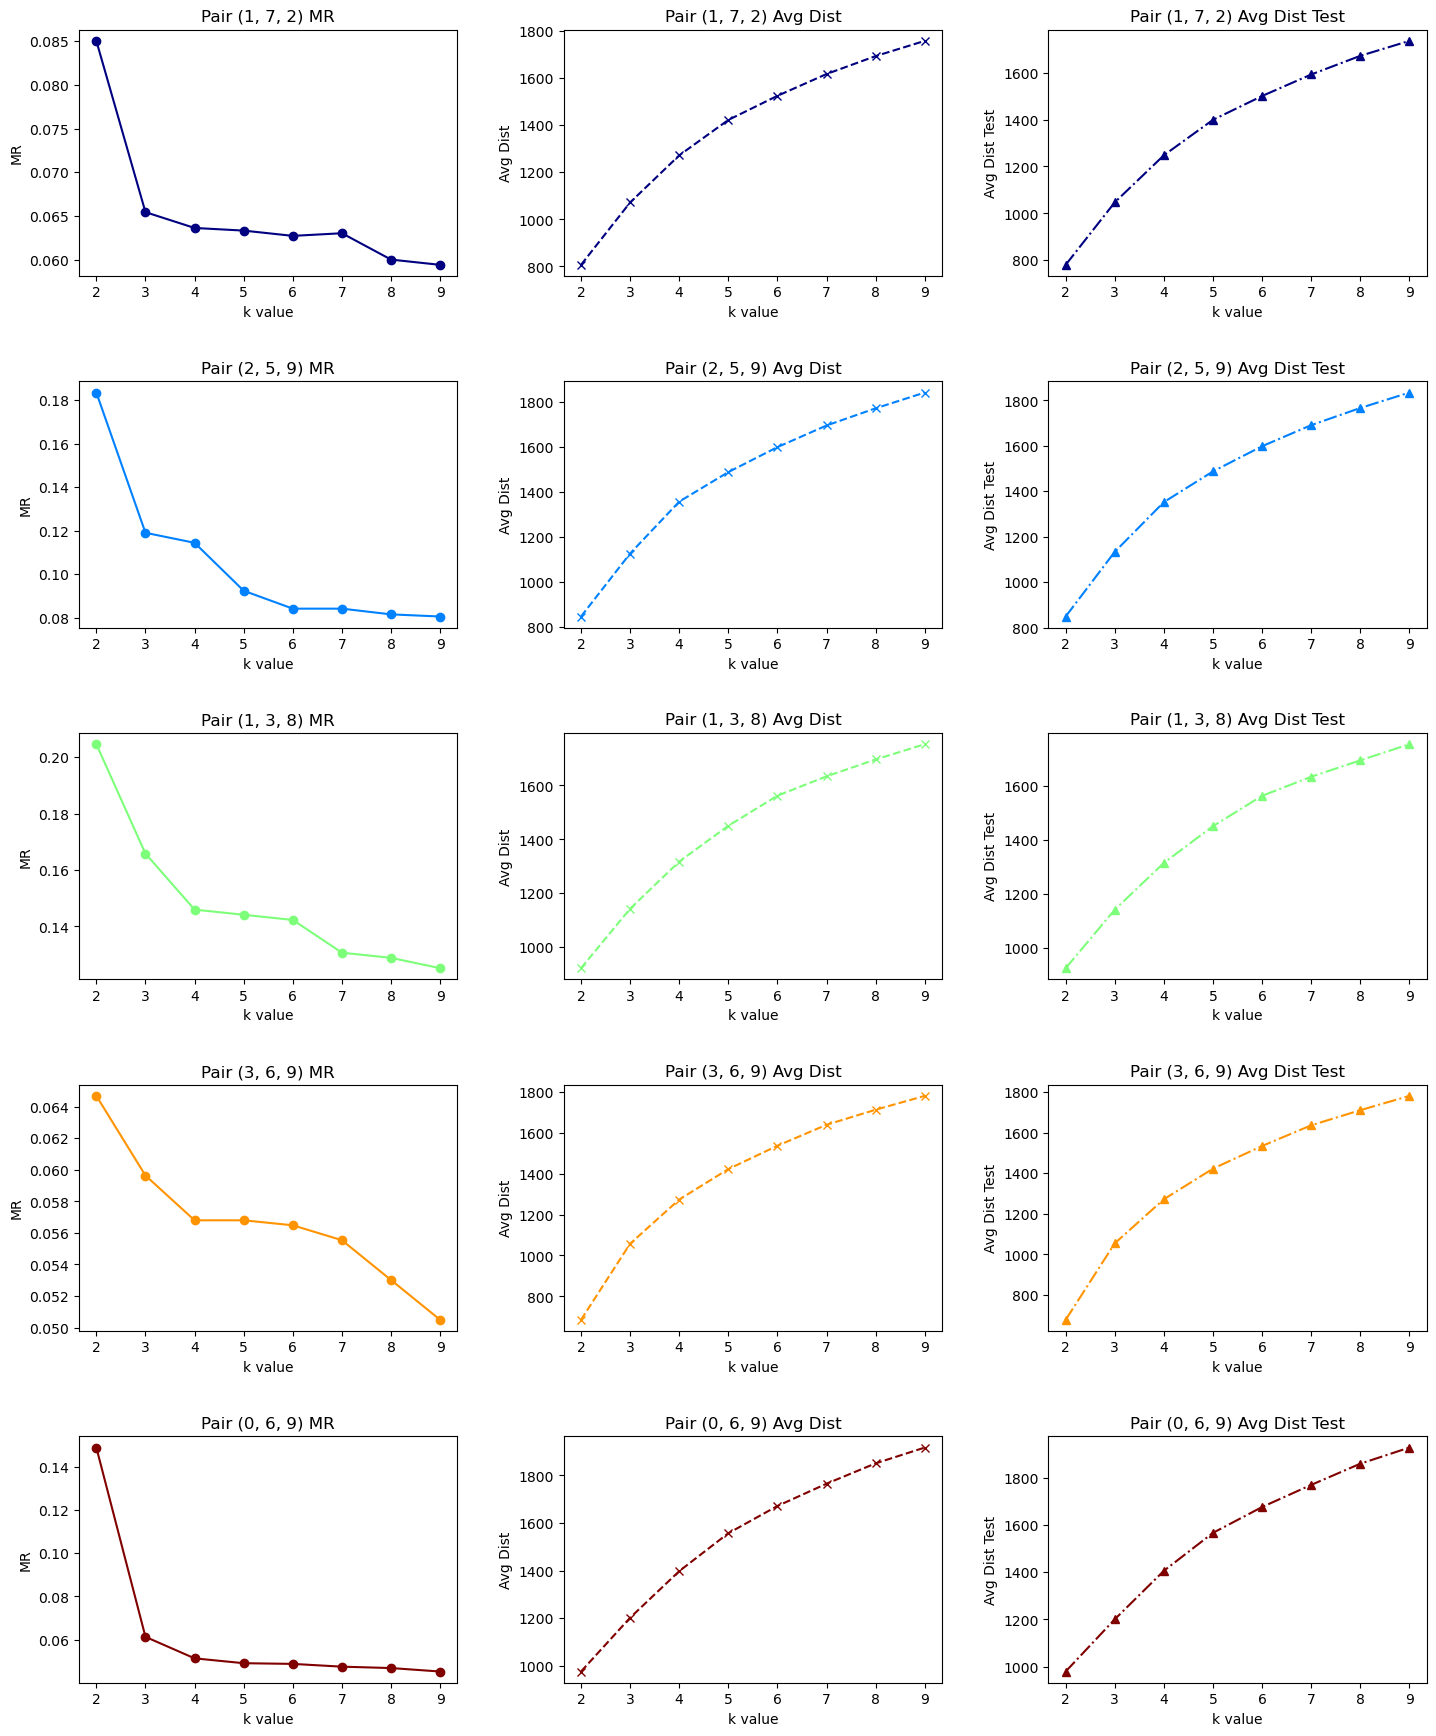

In [17]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 18))

colors = plt.cm.jet(np.linspace(0, 1, len(pairs)))

for idx, pair in enumerate(pairs):
    axs[idx, 0].plot(ks, results[pair]['MR'], marker='o', color=colors[idx], label=f'Pair {pair} MR')
    axs[idx, 0].set_title(f'Pair {pair} MR')
    axs[idx, 0].set_xlabel('k value')
    axs[idx, 0].set_ylabel('MR')

    axs[idx, 1].plot(ks, results[pair]['avg_dist'], marker='x', linestyle='--', color=colors[idx], label=f'Pair {pair} Avg Dist')
    axs[idx, 1].set_title(f'Pair {pair} Avg Dist')
    axs[idx, 1].set_xlabel('k value')
    axs[idx, 1].set_ylabel('Avg Dist')

    axs[idx, 2].plot(ks, results[pair]['avg_dist_test'], marker='^', linestyle='-.', color=colors[idx], label=f'Pair {pair} Avg Dist Test')
    axs[idx, 2].set_title(f'Pair {pair} Avg Dist Test')
    axs[idx, 2].set_xlabel('k value')
    axs[idx, 2].set_ylabel('Avg Dist Test')

fig.tight_layout(pad=3.0)
plt.show()

We can see how the misclassification error decreases with $k$, while the distances increase depending on the $k$. Both of this phenomena are possibly connected with the idea that an higher $k$ (i.e. higher projection dimension) is able to capture more information from the dataset.

In particular, when the $k$ is higher, its projected representation is also more complex, thus amplifying the distance from the center.

#### Compare with other classifier

In [20]:
stats_mr_per_pair = {
    pair: {
        'mean_mr': np.mean(results[pair]['MR']),
        'min_mr': np.min(results[pair]['MR']),
        'max_mr': np.max(results[pair]['MR'])
    } for pair in pairs
}

for pair, stats in stats_mr_per_pair.items():
    print(f"Mean MR for pair {pair}: {stats['mean_mr']:.4f}")
    print(f"Best MR for pair {pair}: {stats['min_mr']:.4f}")
    print(f"Worst MR for pair {pair}: {stats['max_mr']:.4f}")
    print()

Mean MR for pair (1, 7, 2): 0.0653
Best MR for pair (1, 7, 2): 0.0594
Worst MR for pair (1, 7, 2): 0.0850

Mean MR for pair (2, 5, 9): 0.1050
Best MR for pair (2, 5, 9): 0.0806
Worst MR for pair (2, 5, 9): 0.1836

Mean MR for pair (1, 3, 8): 0.1484
Best MR for pair (1, 3, 8): 0.1252
Worst MR for pair (1, 3, 8): 0.2046

Mean MR for pair (3, 6, 9): 0.0567
Best MR for pair (3, 6, 9): 0.0505
Worst MR for pair (3, 6, 9): 0.0647

Mean MR for pair (0, 6, 9): 0.0624
Best MR for pair (0, 6, 9): 0.0453
Worst MR for pair (0, 6, 9): 0.1490



To compare, previously we had:
```
Misclassification error for (1, 7, 2) is 0.0388
Misclassification error for (2, 5, 9) is 0.0946
Misclassification error for (1, 3, 8) is 0.2302
Misclassification error for (3, 6, 9) is 0.1774
Misclassification error for (0, 6, 9) is 0.1212
```

In general, the PCA method performs better than the previous one. It can also be seen how in general the MR is amplified in the SVD method when we have digits that may be considered similar to each other. In some cases, the PCA method performs better even at its lowest. However, in the particular case of (1,7,2), the SVD method performed better than PCA, mostly due to the fact that these digits were generally easier to distinguish thanks to their more subtle details (i.e. the line on the 7).